In [2]:
from Transformer.Config import Config
import torch
import torch.nn as nn
from torch import optim

from Transformer.Trainer.Tokenizer import TokenizerPlus
from Transformer.Trainer.Trainer import Trainer
from Transformer.Trainer.decoding import greedy_decoding
from Transformer.Config import Config
from Transformer.Model import Transformer
import requests
import pandas as pd
url = "https://raw.githubusercontent.com/WegraLee/deep-learning-from-scratch-2/master/dataset/date.txt"
r = requests.get(url)
questions, answers = [], []
for line in r.text.strip().split('\n'):
    idx = line.find('_')
    questions.append(line[:idx].strip())
    answers.append(line[idx:].strip())
df=pd.DataFrame([questions,answers])
df.to_csv("ex1.csv")

tokenizer = TokenizerPlus(char_level=True, filters='')
tokenizer.fit_on_texts(questions)
tokenizer.fit_on_texts(answers)
src = tokenizer.to_tensor(questions)
tgt = tokenizer.to_tensor(answers)


In [30]:

config=Config(len(tokenizer.word_index)+1)
config.n_enc_seq=64
config.n_dec_seq=64
config.d_hidn=64
config.d_ff=128
config.d_head=64
config.n_layer=2
config=Config(len(tokenizer.word_index)+1)

model = Transformer(config)
model.load_state_dict(torch.load('ex1.pth'))

input=tokenizer.to_tensor("august 10, 1994").view(1,-1)
print(input)
print(input.shape,src.shape)
input = torch.cat([torch.zeros(1, src.size(1) - input.size(1)) , input], dim=1).to(torch.int64)

print(input,"\n",input.shape,src.shape)
print(str(tokenizer.to_string(input)))
output,att=greedy_decoding(model,input,tokenizer,"_")
print(output)
print(tokenizer.to_string(input))
output=tokenizer.to_tensor(output).view(1,-1)
print(tokenizer.to_string(output))


tensor([[11, 19, 36, 19, 24, 25,  6,  1,  2,  8,  6,  1,  4,  4, 16]])
torch.Size([1, 15]) torch.Size([50000, 29])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 11, 19, 36, 19,
         24, 25,  6,  1,  2,  8,  6,  1,  4,  4, 16]]) 
 torch.Size([1, 29]) torch.Size([50000, 29])
['august 10, 1994']
['1994-08-10']
['august 10, 1994']
['1994-08-10']


In [65]:
print(output.shape,output)
print(input.shape)
tok_dic={value: key for key, value in tokenizer.word_index.items()}
tok_dic[0]=" "
inputli=[]
for i in list(input[0]):
    inputli.append(tok_dic[int(i.item())])
outputLi=[]
for i in list(output[0]):
    outputLi.append(tok_dic[int(i.item())])

torch.Size([1, 10]) tensor([[ 1,  4,  4, 16,  3,  2, 10,  3,  1,  2]])
torch.Size([1, 29])


In [66]:
print(inputli)
print(outputLi)

[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'a', 'u', 'g', 'u', 's', 't', ' ', '1', '0', ',', ' ', '1', '9', '9', '4']
['1', '9', '9', '4', '-', '0', '8', '-', '1', '0']


In [21]:

print(type(att[1]),len(att),att[1].shape)
dec_enc_att=att[1]
dec_enc_att = torch.sum(dec_enc_att, dim=1)
dec_enc_att=dec_enc_att.view(10,29)
print(dec_enc_att.shape) # (output , input)

<class 'torch.Tensor'> 2 torch.Size([1, 4, 10, 29])
torch.Size([10, 29])


In [69]:
df = pd.DataFrame(dec_enc_att.detach().numpy(),columns=inputli)
df.index = outputLi


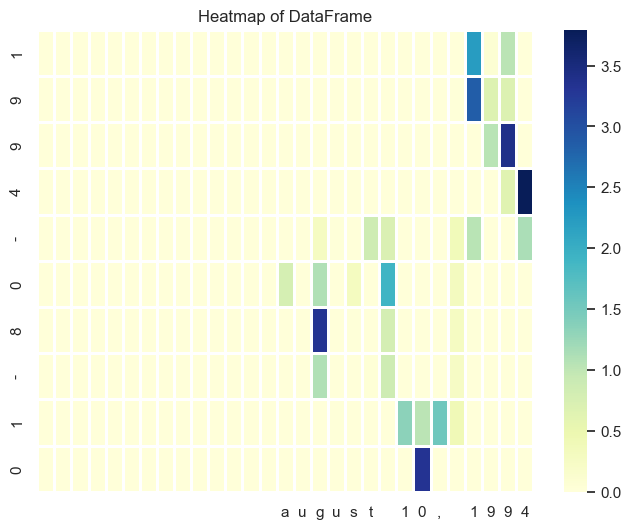

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# 히트맵 생성
plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=False, cmap='YlGnBu', linewidths=1)
plt.title("Heatmap of DataFrame")
plt.show()